### Import the required Libraries

In [1354]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import datetime library
import datetime

# Import math library
import math

# extra - To supress warnings
import warnings
warnings.filterwarnings('ignore')

### Load/Read the CSV file with Lending Information from 2007 - 2011

In [1355]:
loan_data_frame = pd.read_csv('loan.csv', low_memory=False)

### Analyze the dataset shape - Rows count, Columns

In [1356]:
loan_data_frame.shape

(39717, 111)

In [1357]:
loan_data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


#  <font color='green'>1. Data Cleanup</font>

## <font color='blue'>Handling Missing Values</font>
### <font color='brown'>a. Identify & Drop Columns with all Null/NA values</font>

In [1358]:
def drop_columns_inplace(column_names):  #Drop the coulmn from data frame
    loan_data_frame.drop(column_names, axis=1, inplace=True)
    print('Dropped columns: ', column_names)

In [1359]:
loan_data_frame = loan_data_frame.dropna(axis=1, how='all') #Dropping Columns with all NULL values
loan_data_frame.shape

(39717, 57)

### <font color='brown'>b. Identify & Drop Rows with all Null/NA values</font>

In [1360]:
loan_data_frame = loan_data_frame.dropna(axis=0, how='all')  #Dropping Rows with all NULL values
loan_data_frame.shape  #No Rows with all NULL values found

(39717, 57)

### <font color='brown'>c. Identify & Drop Columns which have All Unique values because they won't be useful in our Analysis</font>

In [1361]:
row_count = len(loan_data_frame)
all_unique_values_cols = [column for column in loan_data_frame.columns \
                              if loan_data_frame[column].nunique() == row_count]

drop_columns_inplace(all_unique_values_cols) #Drop the coulmns
loan_data_frame.shape

Dropped columns:  ['id', 'member_id', 'url']


(39717, 54)

### <font color='brown'>d. Identify & Drop Columns which have only ONE value for all the rows without any missing values</font>

In [1362]:
all_one_value_cols = [column for column in loan_data_frame.columns \
                          if loan_data_frame[column].nunique() == 1 and \
                              loan_data_frame[column].value_counts().iloc[0] == row_count \
                     ]

drop_columns_inplace(all_one_value_cols) #Drop the coulmns
loan_data_frame.shape

Dropped columns:  ['pymnt_plan', 'initial_list_status', 'policy_code', 'application_type', 'acc_now_delinq', 'delinq_amnt']


(39717, 48)

### <font color='brown'>e. Identify & Drop columns whose values are Null/NA for More than 90% of the Rows</font>

   #### Column - <font color='red'> next_pymnt_d </font>, Unique Values count - 2 , Nulls row count - 38,577 <br> Column - <font color='red'> mths_since_last_record </font>, Unique Values count - 111 , Nulls row count - 36,931

In [1363]:
ninty_percent_rows_count = round(len(loan_data_frame)*90/100)
cols_to_drop_with_nulls = [column for column in loan_data_frame.columns \
                               if loan_data_frame[column].isna().sum() > ninty_percent_rows_count]

drop_columns_inplace(cols_to_drop_with_nulls)       
loan_data_frame.shape

Dropped columns:  ['mths_since_last_record', 'next_pymnt_d']


(39717, 46)

### <font color='brown'>f. Drop the Columns which have only 1 unique value for more than 99.9% of the rows</font>

#### Column - <font color='red'> collections_12_mths_ex_med </font>, Nulls row count - 56 , Value - 0.0 in 39661 rows <br> Column - <font color='red'> chargeoff_within_12_mths </font>, Nulls row count - 56 , Value - 0.0 in 39661 rows <br>Column - <font color='red'> tax_liens </font>, Nulls row count - 39 , Value - 0.0 in 39678 rows 

In [1364]:
cols_with_less_nulls = ['collections_12_mths_ex_med', 'chargeoff_within_12_mths', 'tax_liens']
for col in cols_with_less_nulls:
    print(loan_data_frame[col].value_counts())
    
drop_columns_inplace(cols_with_less_nulls)
loan_data_frame.shape

collections_12_mths_ex_med
0.0    39661
Name: count, dtype: int64
chargeoff_within_12_mths
0.0    39661
Name: count, dtype: int64
tax_liens
0.0    39678
Name: count, dtype: int64
Dropped columns:  ['collections_12_mths_ex_med', 'chargeoff_within_12_mths', 'tax_liens']


(39717, 43)

### <font color='brown'>g. <font color='red'>desc, title</font> columns are having too many unique values in text format and can't be categorized into buckets. The actual loan reason value is in <font color='red'>purpose</font> column, dropping both these columns from analysis</font>

In [1365]:
drop_columns_inplace(['desc', 'title'])

Dropped columns:  ['desc', 'title']


## <font color='blue'>Handling Incorrect Data Types</font>

#### Group columns based on data type

In [1366]:
cols_by_dtype = loan_data_frame.columns.to_series().groupby(loan_data_frame.dtypes).groups
cols_by_dtype

{int64: ['loan_amnt', 'funded_amnt', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc'], float64: ['funded_amnt_inv', 'installment', 'annual_inc', 'dti', 'mths_since_last_delinq', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'pub_rec_bankruptcies'], object: ['term', 'int_rate', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'zip_code', 'addr_state', 'earliest_cr_line', 'revol_util', 'last_pymnt_d', 'last_credit_pull_d']}

### <font color='brown'>a. Columns to be converted to Numeric - term, int_rate, revol_util</font>

In [1367]:
def replace_and_convert_str_dtype(value, text_to_remove, target_dtype):
    return target_dtype(value.replace(text_to_remove, ''))

#### Remove text ' months' in value for <font color='red'>term</font> column & Convert to Numeric (int)

In [1368]:
print(loan_data_frame['term'].value_counts())
loan_data_frame['term'] = loan_data_frame['term'].apply(lambda val: \
                                                        replace_and_convert_str_dtype(val, ' months', int))
loan_data_frame['term'].dtype

term
 36 months    29096
 60 months    10621
Name: count, dtype: int64


dtype('int64')

#### Remove text '%' in value for <font color='red'>int_rate</font> column & Convert to Numeric (float)

In [1369]:
loan_data_frame['int_rate'] = loan_data_frame['int_rate'].apply(lambda val: \
                                                               replace_and_convert_str_dtype(val, '%', float))
loan_data_frame['int_rate'].dtype

dtype('float64')

#### Impute missing values for <font color='red'>revol_util</font> column as '0%' based on revol_bal column & convert to Numeric (float) by removing '%'

In [1370]:
print(loan_data_frame['revol_util'].value_counts())
loan_data_frame['revol_util'].fillna('0%',inplace=True)
loan_data_frame['revol_util'] = loan_data_frame['revol_util'].apply(lambda val: \
                                                               replace_and_convert_str_dtype(val, '%', float))
loan_data_frame['revol_util'].dtype

revol_util
0%        977
0.20%      63
63%        62
40.70%     58
66.70%     58
         ... 
25.74%      1
47.36%      1
24.65%      1
10.61%      1
7.28%       1
Name: count, Length: 1089, dtype: int64


dtype('float64')

### <font color='brown'>b. Columns to be converted to Date - issue_d, earliest_cr_line, last_credit_pull_d</font>

In [1371]:
month_vals_dict = {'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}
 
def date_conv_func(val):    
    month_name = val.split('-')[0]
    two_digit_year = val.split('-')[1]
    
    if int(two_digit_year) > 80:
        full_year = '19' + two_digit_year
    else:
        full_year = '20' + two_digit_year    
    return datetime.date(int(full_year), month_vals_dict[month_name], 1)

#### Drop Rows where <font color='red'>last_pymnt_d, last_credit_pull_d</font> column has empty/null since number of rows lessthan 0.5%

In [1372]:
loan_data_frame = loan_data_frame[~(loan_data_frame['last_pymnt_d'].isna())]
loan_data_frame = loan_data_frame[~(loan_data_frame['last_credit_pull_d'].isna())]
print(loan_data_frame.shape)

(39644, 41)


#### Convert columns <font color='red'>issue_d, earliest_cr_line, last_pymnt_d, last_credit_pull_d</font> to Date by using the conversion function & Drop old columns

In [1373]:
cols_to_be_converted = ['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d']
for column in cols_to_be_converted:
    loan_data_frame[column+'_dt'] = loan_data_frame[column].apply(date_conv_func)
drop_columns_inplace(cols_to_be_converted)

loan_data_frame.shape

Dropped columns:  ['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d']


(39644, 41)

## <font color='blue'>Imputing Missing Values</font>

### <font color='brown'>a. Impute missing values for column <font color='red'>emp_title</font> with value as 'Others' a new category bucket</font>

In [1374]:
loan_data_frame['emp_title'].isnull().sum()
loan_data_frame['emp_title'].fillna('Others', inplace=True)

### <font color='brown'>b. Impute missing values for column <font color='red'>emp_length</font> with value as 'Others' a new category bucket</font>

In [1375]:
loan_data_frame['emp_length'].value_counts()
loan_data_frame['emp_length'].fillna('Unknown', inplace=True)

### <font color='brown'>c. Dropping <font color='red'>mths_since_last_delinq</font> since the missing values are more than 60% & the columns is having 95 unique values. We can't impute mean/median as the customer might not have been delinq</font>

In [1376]:
drop_columns_inplace(['mths_since_last_delinq'])

Dropped columns:  ['mths_since_last_delinq']


### <font color='brown'>d. Imputing missing values for column <font color='red'>pub_rec_bankruptcies</font> as mean </font>

In [1377]:
mean_value = math.ceil(loan_data_frame['pub_rec_bankruptcies'].mean())
loan_data_frame['pub_rec_bankruptcies'].fillna(float(mean_value), inplace=True)
loan_data_frame.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39644 entries, 0 to 39716
Data columns (total 40 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   loan_amnt                39644 non-null  int64  
 1   funded_amnt              39644 non-null  int64  
 2   funded_amnt_inv          39644 non-null  float64
 3   term                     39644 non-null  int64  
 4   int_rate                 39644 non-null  float64
 5   installment              39644 non-null  float64
 6   grade                    39644 non-null  object 
 7   sub_grade                39644 non-null  object 
 8   emp_title                39644 non-null  object 
 9   emp_length               39644 non-null  object 
 10  home_ownership           39644 non-null  object 
 11  annual_inc               39644 non-null  float64
 12  verification_status      39644 non-null  object 
 13  loan_status              39644 non-null  object 
 14  purpose                  39

### <font color='blue'>ALL CLEANUP Completed </font>

#  <font color='green'>2. Univariate Analysis</font>

### <font color='brown'>a. Categorize columns into Numerical & Categorical </font>

In [1378]:
numerical_cols = loan_data_frame.select_dtypes(['int', 'float']).columns
numerical_cols

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_amnt', 'pub_rec_bankruptcies'],
      dtype='object')

In [1379]:
categorical_cols = loan_data_frame.select_dtypes(['object']).columns
categorical_cols

Index(['grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership',
       'verification_status', 'loan_status', 'purpose', 'zip_code',
       'addr_state', 'issue_d_dt', 'earliest_cr_line_dt', 'last_pymnt_d_dt',
       'last_credit_pull_d_dt'],
      dtype='object')

In [1380]:
#Hold all the Charged off customers info since the focus of our analysis is on Charged Off
charged_off_df = loan_data_frame[loan_data_frame['loan_status']=='Charged Off'] 

### <font color='brown'>b. Define required functions for Univariate Analysis - for all columns simply invoke these  methods </font>

In [1381]:
fontdict_value = {'fontsize': 15, 'fontweight': 5, 'color': 'green'}
# Define required Univariate Chart functions instead of repeating the code multiple times

def generate_count_plot(column, rotation_val=0, order_val=None):
    ax = sns.countplot(x=column, data=charged_off_df, color='red', order=order_val)
    plt.xticks(rotation=rotation_val)
    title = 'Charged Off Customers By '+column+'\n'
    plt.title(title, fontdict=fontdict_value)
    ax.bar_label(ax.containers[0])
    plt.show()

def generate_hist_plot(column):
    sns.histplot(data=charged_off_df, x=column, binwidth=1.0, kde=True)
    title = 'Charged Off Customers By '+column+'\n'
    plt.title(title, fontdict=fontdict_value)
    plt.show()

def generate_hist_plot_with_bins(column, number_of_bins, is_kde=True):
    sns.histplot(data=charged_off_df, x=column, kde=is_kde, bins=number_of_bins)
    title = 'Charged Off Customers By '+column+'\n'
    plt.title(title, fontdict=fontdict_value)
    plt.yticks(np.arange(0,4000,500))
    plt.show()
    
def generate_box_plot(column):
    sns.boxplot(data=charged_off_df, x=column , y='loan_status')
    title = 'Charged Off Customers By '+column+'\n'
    plt.title(title, fontdict=fontdict_value)
    plt.show()


### <font color='brown'>c. Start Univariate Analysis for Numerical Columns </font>

#### Not invoking the charts using loop because the scorlling is difficult hence invoking them sequentially one by one

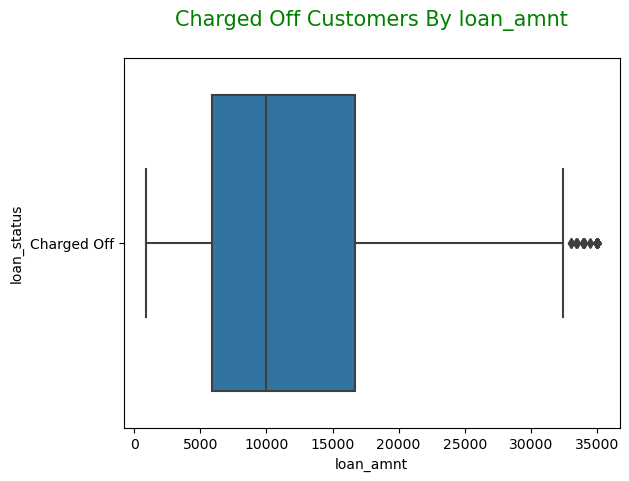

In [1382]:
generate_box_plot('loan_amnt') 
#Observation - 75% of Charged off customers have taken loan <20k
### loan amnt, funded amnt, funded_amnt_inv columns are like identical. One of them should be enough for analysis

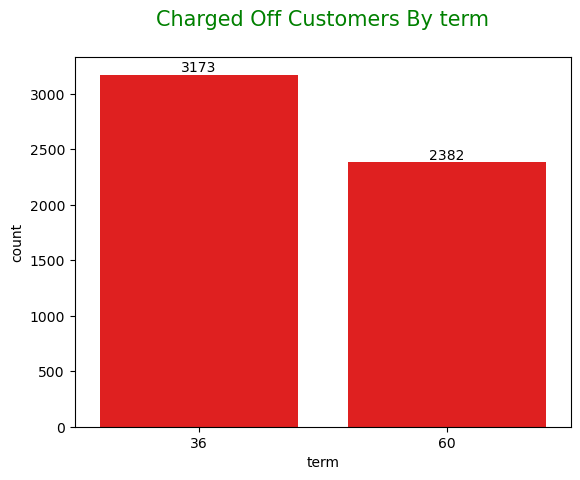

In [1383]:
generate_count_plot('term')   
## Term - 36 Months is having more Charged off than 60 Months

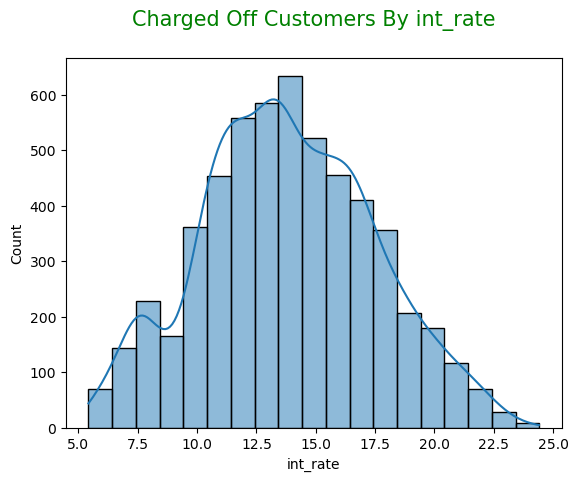

In [1384]:
generate_hist_plot('int_rate')  #obssevation - most of the people intrest rates are between 10 to 15%

#### Convert int_rate into buckets with ranges

In [1385]:
loan_data_frame['int_rate_cat'] = pd.cut(loan_data_frame['int_rate'], bins=4, labels=['5-10','10-15','15-20','20-25'])
charged_off_df['int_rate_cat'] = loan_data_frame['int_rate_cat']
loan_data_frame['int_rate_cat'].value_counts()

int_rate_cat
10-15    18668
5-10     12468
15-20     7543
20-25      965
Name: count, dtype: int64

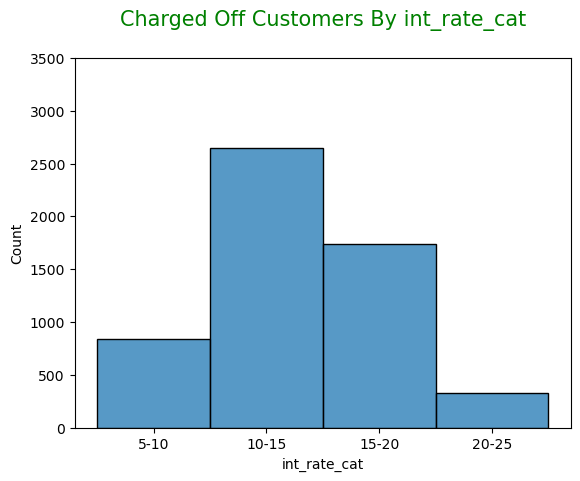

In [1386]:
generate_hist_plot_with_bins('int_rate_cat', 4, False)
#obssevation - Most of the Chargedoff customers interest_rate is between 10%-20%

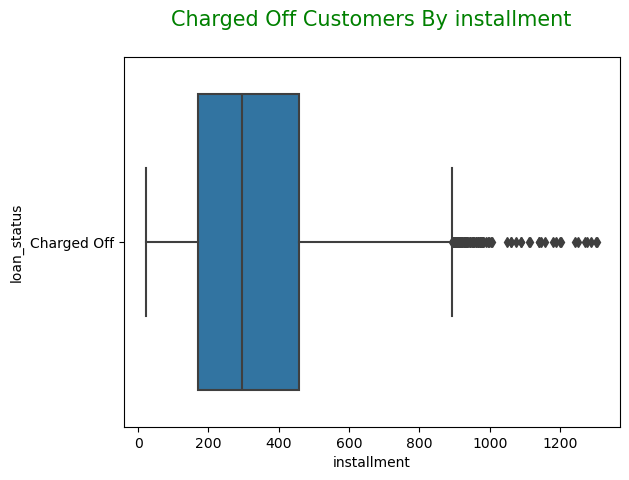

In [1387]:
generate_box_plot('installment') 
#Instalment Amount of Chargedoff Customers upper quartile range is less than 900$

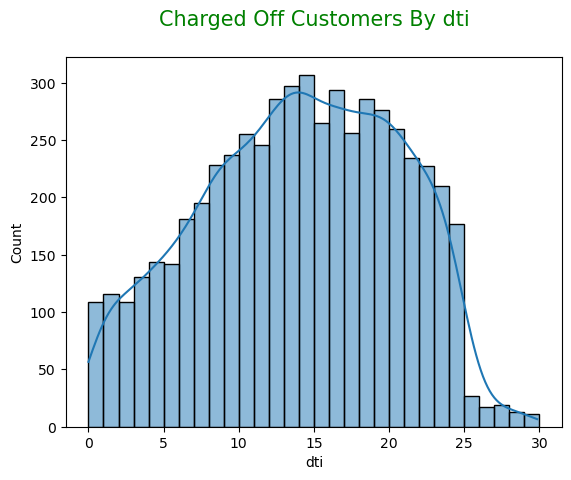

In [1388]:
generate_hist_plot('dti')
## observations - need to check if high DTI , status of the loan - categorize into buckets

#### Convert dti into buckets with ranges

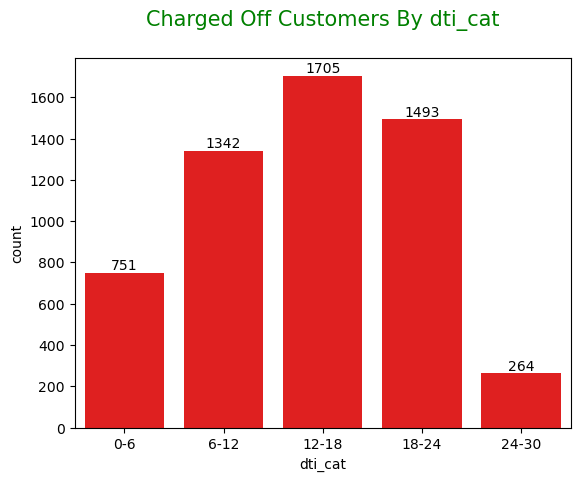

In [1389]:
loan_data_frame['dti_cat'] = pd.cut(loan_data_frame['dti'], bins=5, \
                                    labels=['0-6','6-12','12-18','18-24','24-30'])
charged_off_df['dti_cat'] = loan_data_frame['dti_cat']

generate_count_plot('dti_cat')
#Observation - 12-18 & then 18-24% dti are having highest Charged Offs respectively

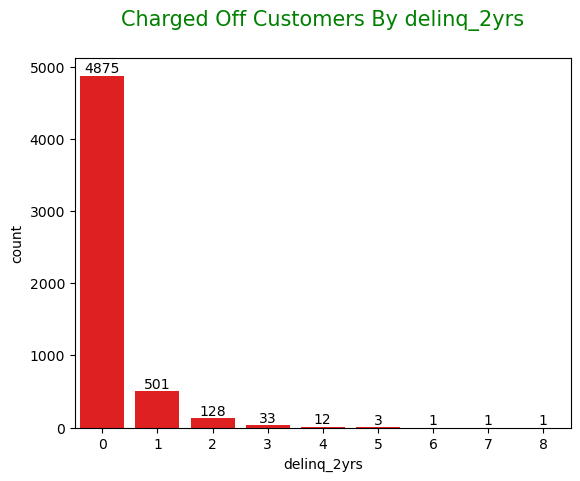

In [1390]:
generate_count_plot('delinq_2yrs')
#Observation - Majority of the customers delinq_2yrs is 0 and also the count is high in Charged Off

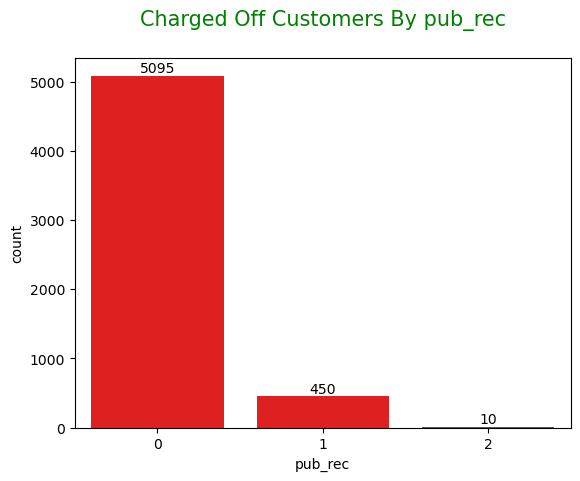

In [1391]:
generate_count_plot('pub_rec')

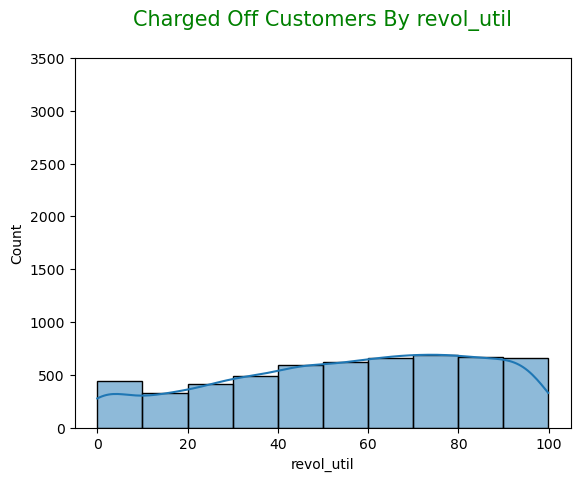

In [1392]:
generate_hist_plot_with_bins('revol_util', 10) 
# seems evenly distributed & Might not be useful for Bivariate Analysis

#### Categorize annual_inc into 6 buckets - 0-20k, 20-40k etc.. & analyze

In [1393]:
loan_data_frame['annual_inc_cat'] = pd.cut(loan_data_frame['annual_inc'], bins=np.arange(0,120001,20000),\
                                           labels=['0-20k','20-40k','40-60k','60-80k','80-100k','100k+'])
charged_off_df['annual_inc_cat'] = loan_data_frame['annual_inc_cat']
# We will be using this new column annual_inc_cat for Bivariate analysis later

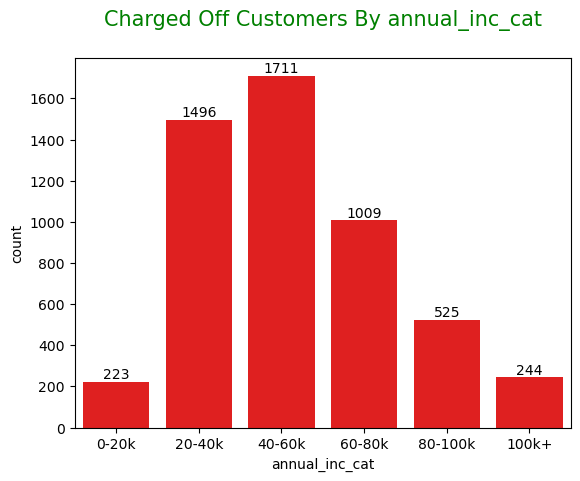

In [1394]:
generate_count_plot('annual_inc_cat')
# 40-60k range income has has ChargedOffs followed by 20-40k. Need to analyze more in Bivariate

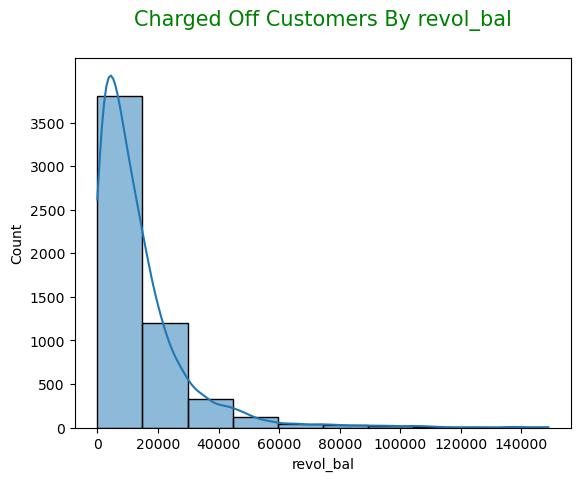

In [1395]:
generate_hist_plot_with_bins('revol_bal', 10)
#observation - Most of revol_bal is less than 10k for ChargedOffs

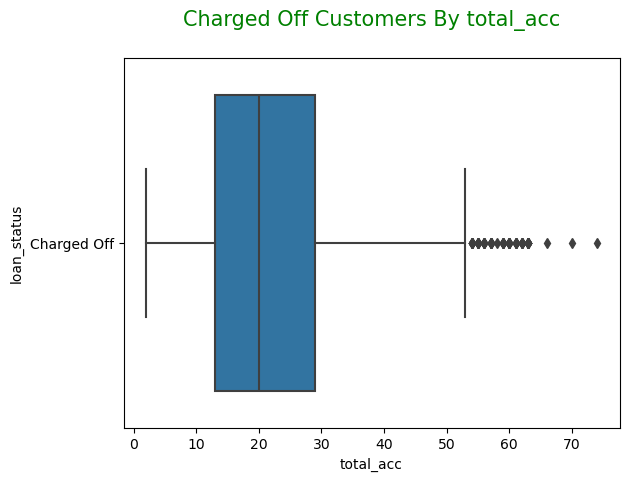

In [1396]:
generate_box_plot('total_acc')

### <font color='brown'>d. Start Univariate Analysis for Categorical Columns </font>

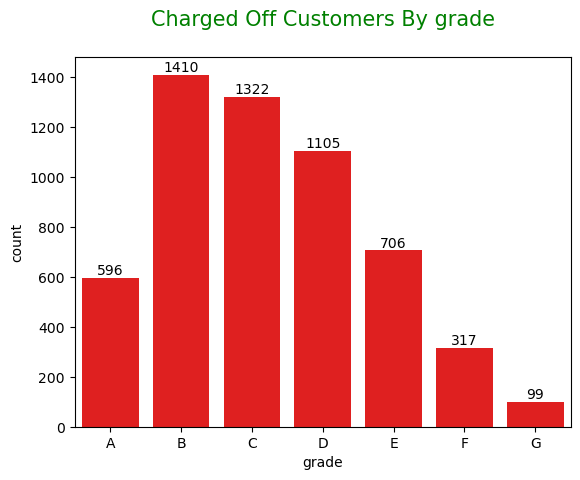

In [1397]:
generate_count_plot('grade', 0, ['A', 'B', 'C', 'D', 'E', 'F', 'G'])
#Observation - Most of the borrowers fallen Grade-B -> Grade-Interstrate-Loan staus need to analyze for defaulters

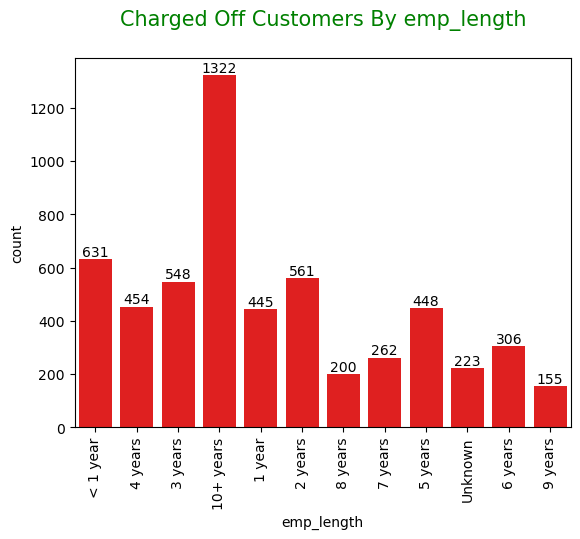

In [1398]:
generate_count_plot('emp_length', 90)
## Observations - Most of the ChrgedOff customers are 10+years exp

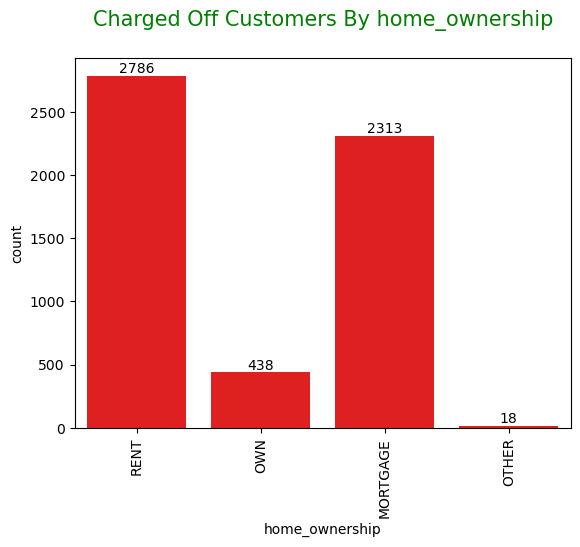

In [1399]:
generate_count_plot('home_ownership', 90)
#observation- none & other are negligible counts, can be dropped. Ownership doesn't seems to have much impact

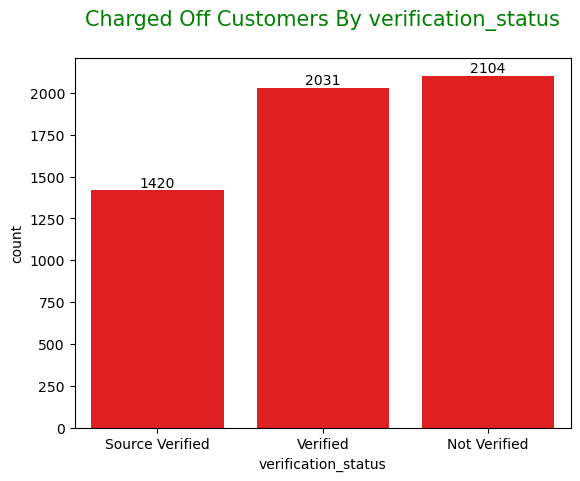

In [1400]:
generate_count_plot('verification_status')
#observation - Both Verified & Not Verified customers count is almost same,except source verified count is less

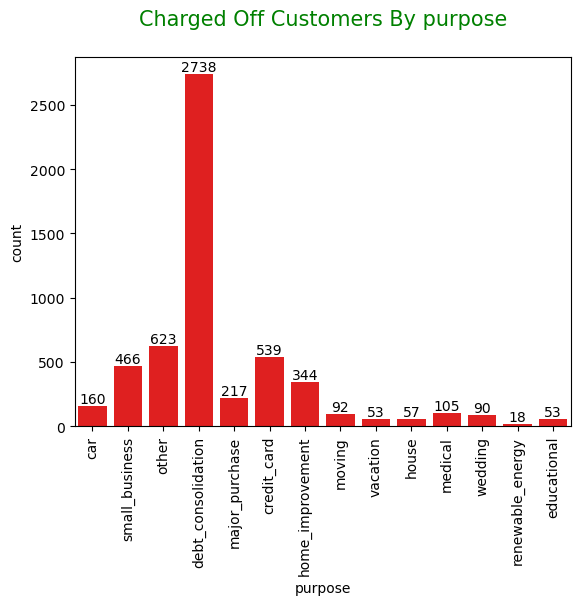

In [1401]:
generate_count_plot('purpose', 90)
## Observation - most of the purpose debt_consolidation,credit card

#  <font color='green'>3. Bivariate Analysis</font>

In [1402]:
without_current_df = loan_data_frame[~(loan_data_frame['loan_status'] == 'Current')]

### <font color='brown'>a. Define required functions for Bivariate analysis </font>

In [1446]:
fontdict_value = {'fontsize': 15, 'fontweight': 5, 'color': 'green'}

def generate_bar_plot(x_column, y_column, hue_column, rotation_value=0, display_counts=False, order_val=None):
    plt.figure(figsize=(8,5))
    ax = sns.barplot(data=without_current_df, x=x_column, y=y_column, hue=hue_column, order=order_val)
    plt.xticks(rotation=rotation_value)
    if (display_counts):
        ax.bar_label(ax.containers[1], fontsize=10);
    plt.title(f'Loan Status of Customers by {x_column} and {y_column}', fontdict=fontdict_value)
    plt.show()

def generate_line_plot(x_column, y_column, hue_column, rotation_value=0, custom_yticks=False):
    sns.lineplot(data=without_current_df, x=x_column, y=y_column, hue=hue_column)
    plt.title(f'Loan Status of Customers by {x_column} and {y_column}', fontdict=fontdict_value)
    if (custom_yticks):
        plt.yticks(custom_yticks, custom_yticks)
    plt.show()

def generate_hist_plot(x_column, hue_column, rotation_value=0, multiple_val='stack'):
    plt.figure(figsize=(10,5))
    ax = sns.histplot(data=without_current_df, x=x_column, hue=hue_column, multiple=multiple_val, binwidth=1.0)
    plt.title(f'Loan Status of Customers by {x_column}', fontdict=fontdict_value)
    plt.xticks(rotation=rotation_value)
    ax.bar_label(ax.containers[0], label_type='center')
    plt.show()

### <font color='brown'>b. Generate Bar plots with loan_status as hue with different combinations sequentially</font>

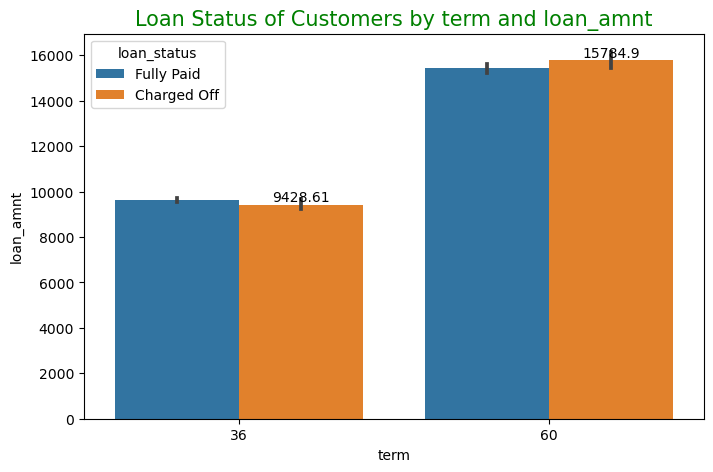

In [1404]:
generate_bar_plot('term', 'loan_amnt', 'loan_status', display_counts=True)
#observation - Term 60 Months with Loan Amount mean 15k+ has more ChargedOffs than term 36 months

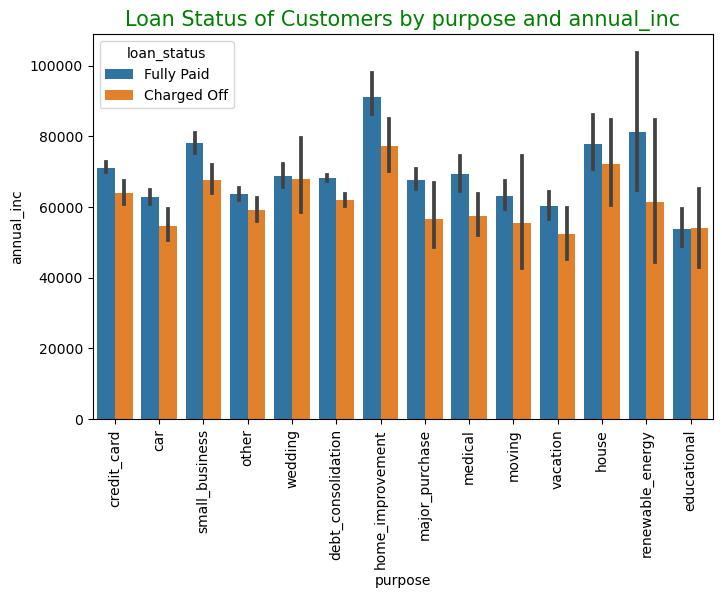

In [1405]:
generate_bar_plot('purpose', 'annual_inc', 'loan_status', 90)
#observation - Purpose Home Improvement, House having high ChargedOffs with Annual Income range 60-80k

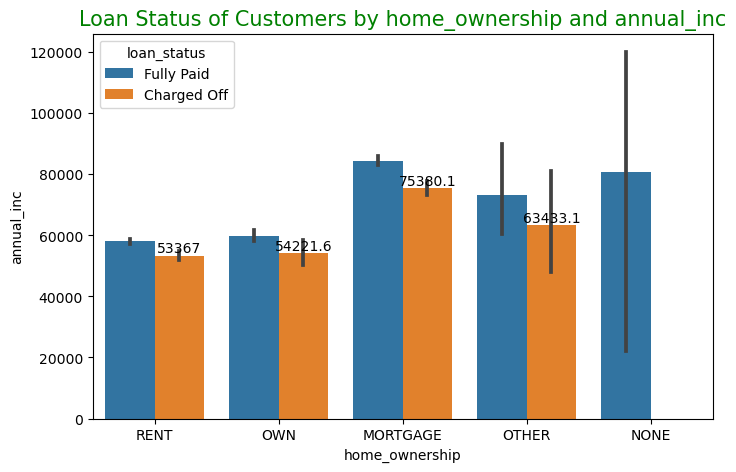

In [1406]:
generate_bar_plot('home_ownership', 'annual_inc', 'loan_status', display_counts=True)
##Observation Annaul Income - Avg 75k & Home Ownership - Mortgage have high Charged Off

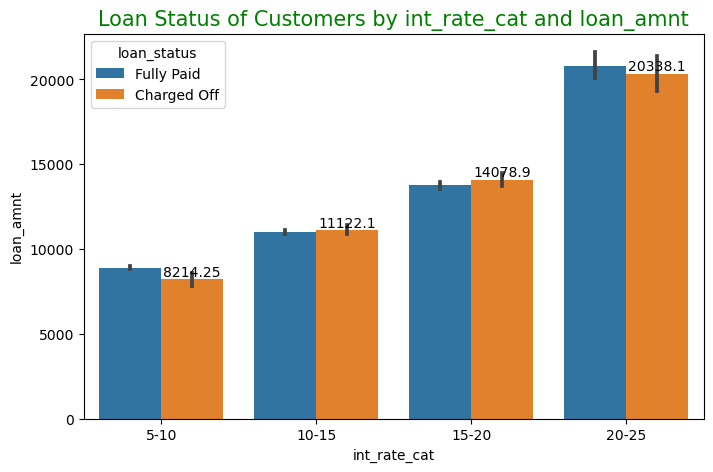

In [1407]:
generate_bar_plot('int_rate_cat', 'loan_amnt', 'loan_status', display_counts=True)
#observation - High interest rate 20-25% has high Charged Offs with Mean Loan Amount 20k+

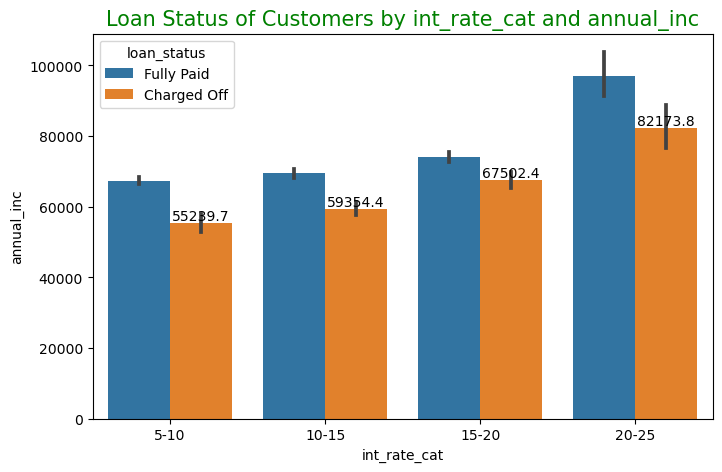

In [1408]:
generate_bar_plot('int_rate_cat', 'annual_inc', 'loan_status', display_counts=True)
#Observation - High interest rate 20-25% has high Charged Offs even if Annual Income is high (Mean 80k+)

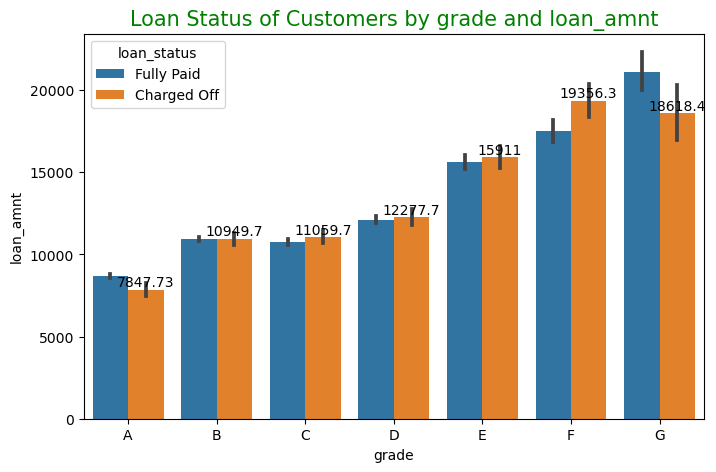

In [1409]:
generate_bar_plot('grade', 'loan_amnt', 'loan_status', display_counts=True, order_val=['A','B','C','D','E','F','G'])
#Observation - Customer Grades F & G are high likely to be ChargedOffs with mean Loan Amounts 18k+

### <font color='brown'>c. Heatmap with grouping of Grade, int_rate_cat & Agg by loan_status</font>

In [1413]:
without_current_df['loan_status_num'] = without_current_df['loan_status'].map({'Charged Off': 0, 'Fully Paid': 1})
# Aggregate data to get the charge-off rate for each combination of loan_purpose and loan_grade
heatmap_data = without_current_df.groupby(['grade', 'int_rate_cat'])['loan_status_num'].mean().unstack()
print(heatmap_data)

int_rate_cat      5-10     10-15     15-20     20-25
grade                                               
A             0.940626       NaN       NaN       NaN
B             0.897994  0.874316       NaN       NaN
C             1.000000  0.835473  0.767857       NaN
D             1.000000  0.818779  0.766150       NaN
E             1.000000  0.759259  0.742927  0.584906
F                  NaN       NaN  0.736185  0.590799
G                  NaN       NaN  0.650000  0.667870


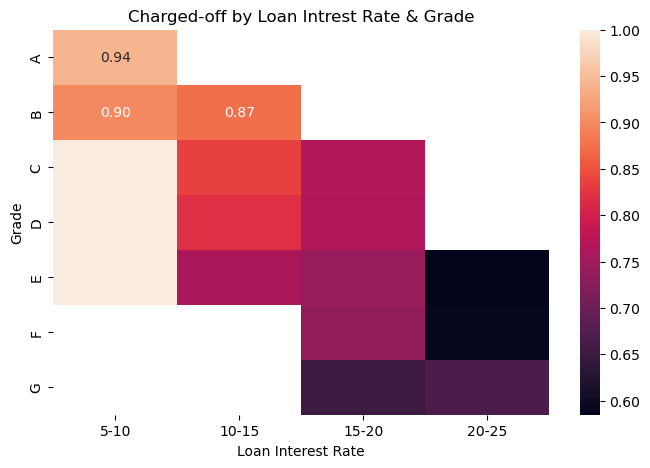

In [1414]:
# Create heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(heatmap_data, annot=True, fmt=".2f")
plt.title('Charged-off by Loan Intrest Rate & Grade')
plt.xlabel('Loan Interest Rate')
plt.ylabel('Grade')
plt.show()

                 loan_amnt  int_rate  installment  loan_status_num  open_acc  \
loan_amnt         1.000000  0.301894     0.932160        -0.061573  0.176640   
int_rate          0.301894  1.000000     0.277783        -0.210217  0.006587   
installment       0.932160  0.277783     1.000000        -0.028837  0.172276   
loan_status_num  -0.061573 -0.210217    -0.028837         1.000000  0.007023   
open_acc          0.176640  0.006587     0.172276         0.007023  1.000000   
pub_rec          -0.049735  0.098331    -0.045446        -0.050555  0.000386   

                  pub_rec  
loan_amnt       -0.049735  
int_rate         0.098331  
installment     -0.045446  
loan_status_num -0.050555  
open_acc         0.000386  
pub_rec          1.000000  


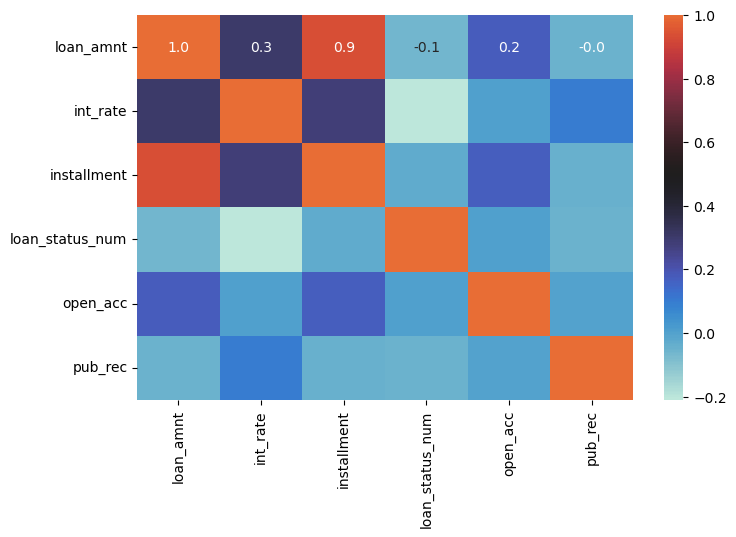

In [1416]:
plt.figure(figsize=(8,5))
cont_var= ['loan_amnt', 'int_rate', 'installment', 'loan_status_num', 'open_acc', 'pub_rec']
corr = without_current_df[cont_var].corr()
print(corr)
sns.heatmap(corr, annot=True, center=0.5, fmt='.1f')
plt.show()

### <font color='brown'>c. Histograms </font>

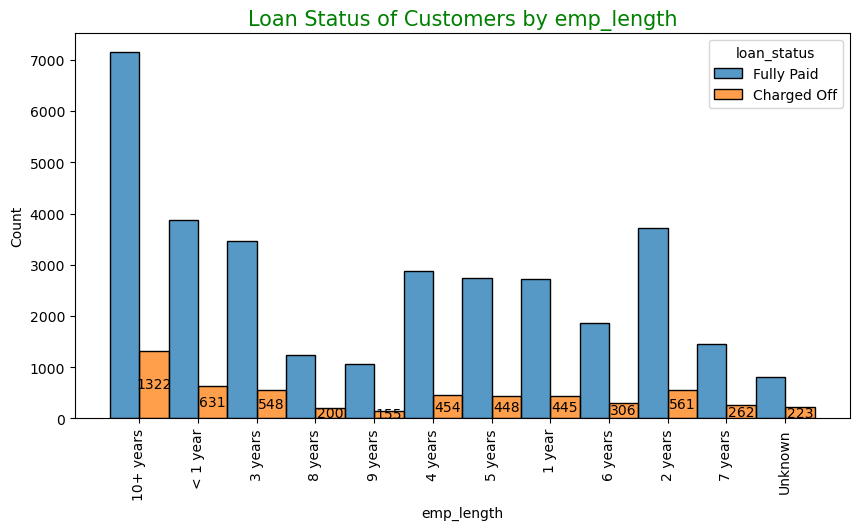

In [1447]:
generate_hist_plot('emp_length', 'loan_status', multiple_val='dodge', rotation_value=90)
#observation - 10+ years emp_length customers are the most defaulted

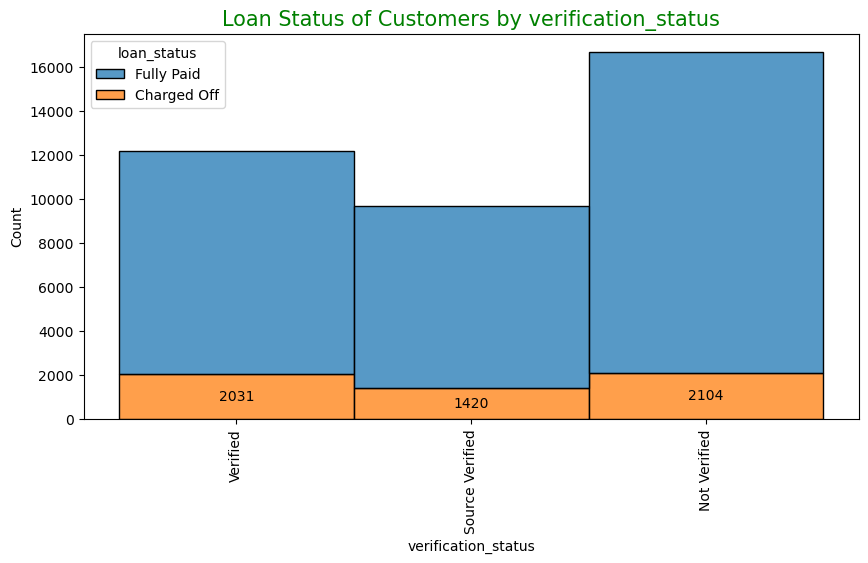

In [1448]:
generate_hist_plot('verification_status', 'loan_status', multiple_val='stack', rotation_value=90)
#Observation - Verification status Not Verified has high Charged Offs followed by Veified status

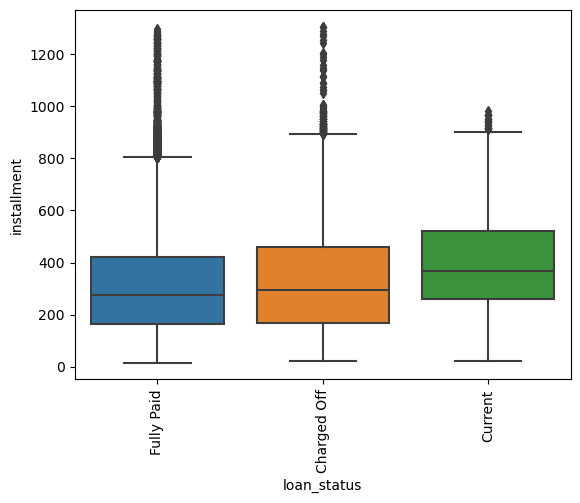

In [1042]:
sns.boxplot(data=loan_data_frame,y='installment',x='loan_status')
plt.xticks(rotation=90)
plt.show()

### <font color='brown'>d. LinePlot - Based on year wise continuous data</font>

In [1420]:
without_current_df['issue_d_year'] = without_current_df['issue_d_dt'].apply(lambda value: str(value.year))
without_current_df['issue_d_year'].value_counts()

issue_d_year
2011    20478
2010    11511
2009     4704
2008     1561
2007      250
Name: count, dtype: int64

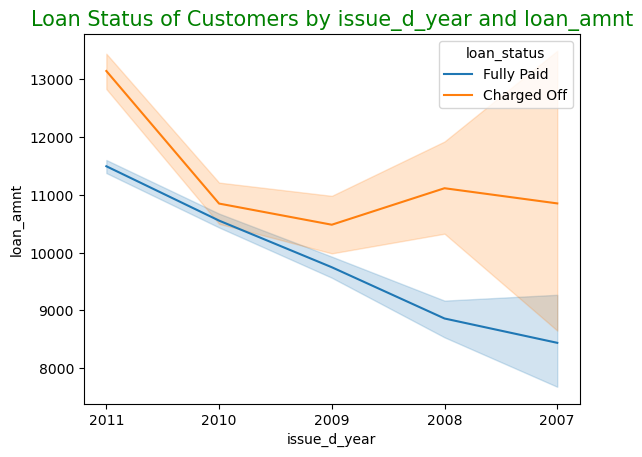

In [1421]:
generate_line_plot('issue_d_year', 'loan_amnt', 'loan_status')
#observation - Every year the loan amounts are increasing except there is a dip from year 2008 -> to 2009 

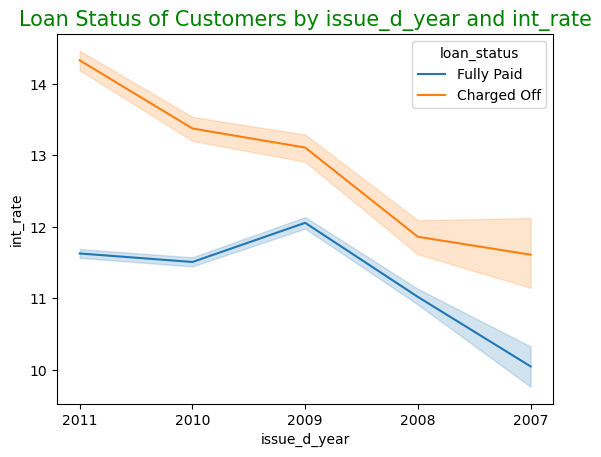

In [1450]:
generate_line_plot('issue_d_year', 'int_rate', 'loan_status')
#observation - Almost every year the loan interest rates are increasing for Charged Off customers but for Fully Paid there is down trend in yesr 2009

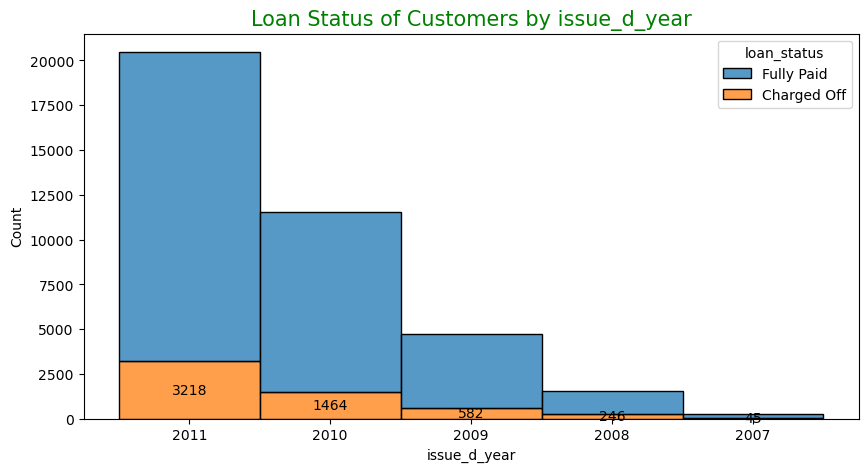

In [1449]:
generate_hist_plot('issue_d_year', 'loan_status', multiple_val='stack')
#observation - Every year the Charged off customers count as well as the number of loans given are increasing

## Overall Observations - Consolidated
### <font color='green'> Approximately 14% of loans are charged off</font>
### <font color='green'> Customer Grades F & G are high likely to be ChargedOffs with mean Loan Amounts 18k+</font>
### <font color='green'> High interest rate 20-25% has high Charged Offs with Mean Loan Amount 20k+ </font>
### <font color='green'> Annaul Income - Avg 75k & Home Ownership - Mortgage have high Charged Offs </font>
### <font color='green'> Purpose - Home Improvement, House having high ChargedOffs with Annual Income range 60-80k</font>
### <font color='green'> Every year the Charged off customers count as well as the number of loans given are increasing</font>
    